## We would like to know in advance when we have to request additional servers in the cloud to serve all the incoming requests successfully without paying for unused ones, when we hit limit requests per hour

In [41]:
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the data

In [50]:
data = pd.read_table('../Building_ML_System/1400OS_01_Codes/data/web_traffic.tsv', sep='\t', header=None)
#data = sp.genfromtxt("../Building_ML_System/1400OS_01_Codes/data/web_traffic.tsv", delimiter="\t")

# Preprocessing and cleaning the data

In [51]:
data = data.dropna()

# separate the dimensions into two vectors x & y

 x contain the hours , y contian the web hits in that particular hour 

In [52]:
x = data.ix[:,0]
y = data.ix[:,1]

# Plot the data in scatter plot using Matplotlib

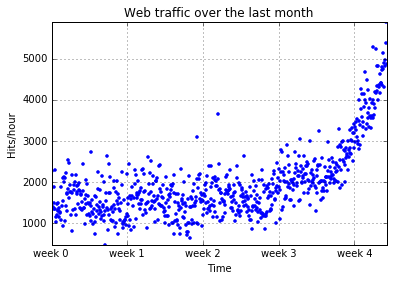

In [53]:
%matplotlib inline
plt.figure("origin")
plt.plot(x, y, '.')
plt.title('Web traffic over the last month')
plt.xlabel('Time')
plt.ylabel('Hits/hour')
#xticks()第一个是文字的位置，第二个是具体的文字说明
plt.xticks([w*7*24 for w in range(10)], 
           ['week %i'%w for w in range(10)])
plt.autoscale(tight=True)
plt.grid()
plt.show()

# Choosing the right model and learning algorithm

- Find the real model behind the noisy data points
- Use the model to extrapolate into the future to find the point in time where our infrastructure has to be extended

In [26]:
# calculated the squared distance of the model's prediction to the real data
def error(f, x, y) :
    return sp.sum( (f(x) - y)**2 )

# Starting with a simple straight line

In [27]:
fp1, residuals, rank, sv, rcond = sp.polyfit(x, y, 1, full=True)

In [28]:
# parameters of the fitted model function
print("Model parameters : %s" %fp1)

Model parameters : [   2.59619213  989.02487106]


In [29]:
# error of the approximation
print residuals

[  3.17389767e+08]


In [30]:
# we then use poly1d() to create a model function from the model parameters
f1 = sp.poly1d(fp1)
print error(f1, x, y)

317389767.34


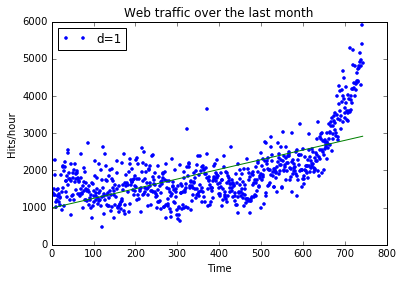

In [56]:
# use the f1 model to plot our trained model, in addition to the earlier plotting instruction

plt.plot(x, y , '.',
         x, f1(x), '-')
plt.title('Web traffic over the last month')
plt.xlabel('Time')
plt.ylabel('Hits/hour')
plt.legend(["d=%i" % f1.order], loc = "upper left")

# Towards some advanced stuff

In [64]:
# fit a more complex model , a polynomial of degree 2 
f2p = sp.polyfit(x, y, 2)
print f2p
f2 = sp.poly1d(f2p)
print error(f2, x, y)

# fit a model with polynomial of degree3
f3p = sp.polyfit(x, y, 3)
f3 = sp.poly1d(f3p)

# fit a model with polynomial of degree 10
f10p = sp.polyfit(x, y, 10)
f10 = sp.poly1d(f10p)

# fit a model with polynomial of degree 100
f100p = sp.polyfit(x, y, 100)
f100 = sp.poly1d(f100p)


[  1.05322215e-02  -5.26545650e+00   1.97476082e+03]
179983507.878


/home/zpgao/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


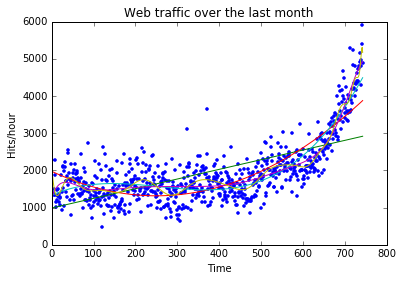

In [69]:
plt.plot(x, y , '.',
         x, f1(x), '-', 
         x, f2(x), '-', 
         x, f3(x), '-',
         x, f10(x), '-',
         x, f100(x), '-')
plt.title('Web traffic over the last month')
plt.xlabel('Time')
plt.ylabel('Hits/hour')

In [75]:
print "Error d = 1: " + str(error(f1, x, y))
print "Error d = 2: " + str(error(f2, x, y))
print "Error d = 3: " + str(error(f3, x, y))
print "Error d = 10: " + str(error(f10, x, y))
print "Error d = 100: " + str(error(f100, x, y))

Error d = 1: 317389767.34
Error d = 2: 179983507.878
Error d = 3: 139350144.032
Error d = 10: 121942326.364
Error d = 100: 109452402.26


Looking at the polynomial of degree 10 and 100, we see wildly oscillating behavior. It seems that the models are fitted too much to the data. So much that it is now capturing not only the underlying prcess but also the noise.This is overfitting.

# Stepping back and go forward 

- There seems that there is an inflection point between 3 and 4 .
- We train the first line with the data up to week3, and the second line with the remaining data.

In [85]:
inflection = 3.5 * 7 * 24 # the inflection point in hours
xa = x.ix[0:inflection]
ya = y.ix[0:inflection]
xb = x.ix[inflection:]
yb = y.ix[inflection:]

fa = sp.poly1d( sp.polyfit(xa, ya, 1) )
fb = sp.poly1d( sp.polyfit(xb, yb, 1) )

fa_error = error(fa, xa, ya)
fb_error = error(fb, xb, yb)

print 'Error inflection : %f' %( fa_error + fb_error )

Error inflection : 135034543.898478


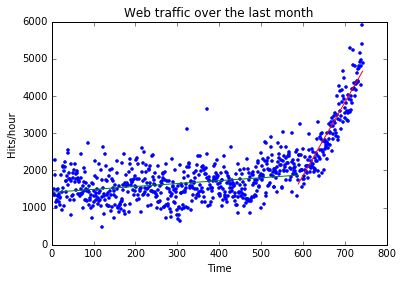

In [87]:
# Plotting the two models 
plt.plot(x, y , '.',
         xa, fa(xa), '-',
         xb, fb(xb), '-') 
plt.title('Web traffic over the last month')
plt.xlabel('Time')
plt.ylabel('Hits/hour')

clearly the combination of these tow lines seems to be a much better fit to the data 